In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

# import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchmetrics as TM
# pl.utilities.seed.seed_everything(seed=42)
import numpy as np
import pandas as pd

import sys, os
source_path = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(source_path)
source_path = os.path.join(os.getcwd(), os.pardir, 'preprocessing')
sys.path.append(source_path)
source_path = os.path.join(os.getcwd(), os.pardir, 'metrics')
sys.path.append(source_path)
import matplotlib.pyplot as plt

from dl import NeuralNetwork, Trainer
from preprocess import (
    show_df, 
    date_features, 
    preprocess, 
    ToTorch, 
    get_loader, 
    ts_split,
    cont_cat_split,
    dataloader_by_stock,
    get_train_data
)
from metrics import calc_spread_return_sharpe
print(torch.__version__)

C:\Users\gilbe\anaconda3\envs\tokyo\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.11.0


In [2]:
print(torch.version.cuda), torch.cuda.is_available(), torch.cuda.device_count()

11.3


(None, True, 1)

##  Get Data and train a Neural Network

# Get the unique security codes

In [3]:
train_df = get_train_data()
print('Unique adjustment factor:', train_df['AdjustmentFactor'].unique())
print(train_df['AdjustmentFactor'])
train_df.head()

Unique adjustment factor: [ 1.          0.5         5.          0.33333333  0.83333333  0.25
  0.90909091  0.1        10.          0.2         0.95238095  2.
  0.14285714  0.66666667  0.86956522  0.76923077  0.8         4.
 20.        ]
Date
2017-01-04    1.0
2017-01-04    1.0
2017-01-04    1.0
2017-01-04    1.0
2017-01-04    1.0
             ... 
2021-12-03    1.0
2021-12-03    1.0
2021-12-03    1.0
2021-12-03    1.0
2021-12-03    1.0
Name: AdjustmentFactor, Length: 2332531, dtype: float64


,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
Date,,,,,,,,,,,
2017-01-04,20170104_1301,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
2017-01-04,20170104_1332,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2017-01-04,20170104_1333,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
2017-01-04,20170104_1376,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
2017-01-04,20170104_1377,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


# Create model

### Args and constants

In [4]:
CONT_COLS=['Close', 'Open', 'High', 'Low']
TS_IN_FEATURES = len(CONT_COLS)
CAT_FEATURES = 4 #cat.shape[1]
print('CAT_FEATURES:', CAT_FEATURES)
EMBEDDING_DIM = 300
NO_EMBEDDING = 2000 #2 * len(df_train_cat)

CAT_FEATURES: 4


In [5]:


model = NeuralNetwork(
    in_features=TS_IN_FEATURES, 
    units=512,
    out_features=1, 
    categorical_dim=CAT_FEATURES,
    no_embedding=NO_EMBEDDING, 
    emb_dim=EMBEDDING_DIM,
    n_blocks=6,
    n_stacks=3,
    dropout=0.1
)

print(model)

NeuralNetwork(
  (embedding): Embedding(2000, 300)
  (embedding_to_hidden): Linear(in_features=300, out_features=512, bias=True)
  (embedding_output): Linear(in_features=512, out_features=1, bias=True)
  (cont_input): Linear(in_features=4, out_features=512, bias=True)
  (hidden_layer): Linear(in_features=516, out_features=516, bias=True)
  (output_layer): Linear(in_features=516, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (stacks): ModuleList(
    (0): NeuralStack(
      (stacks): ModuleList(
        (0): NeuralBlock(
          (dropout): Dropout(p=0.1, inplace=False)
          (layer1): Linear(in_features=516, out_features=516, bias=True)
          (layer2): Linear(in_features=516, out_features=516, bias=True)
          (layer3): Linear(in_features=516, out_features=516, bias=True)
          (layer4): Linear(in_features=516, out_features=516, bias=True)
          (output): Linear(in_features=516, out_features=516, bias=True)
          (res_output): Linear(i

# Loop throug each stock
Create Trainer only once

Using cuda-device
Start training for stock: 1301


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\anaconda3\envs\tokyo\lib\site-packages\torch\autograd\__init__.py:173: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Copy.cpp:239.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Train metrics: {'mse': 2.3815460205078125, 'mae': 1.5172436237335205}
Validation metrics: {'mse': 0.1318303346633911, 'mae': 0.3328804671764374}
Average train loss: 0.029018032550811767 | Average val loss: 0.28113657236099243
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 1.453399419784546, 'mae': 1.1696419715881348}
Validation metrics: {'mse': 0.026692157611250877, 'mae': 0.13537077605724335}
Average train loss: 0.015584518015384675 | Average val loss: 0.10932943224906921
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.8488809466362, 'mae': 0.8831595778465271}
Validation metrics: {'mse': 0.038519784808158875, 'mae': 0.15388284623622894}
Average train loss: 0.01247401386499405 | Average val loss: 0.07204832881689072
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.4900309145450592, 'mae': 0.6615096926689148}
Validation metrics: {'mse': 0

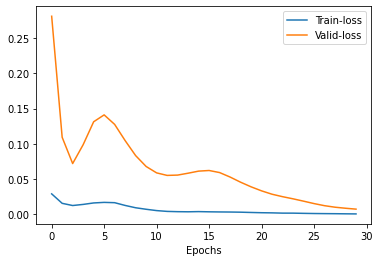

####################

Start training for stock: 1332
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.032505664974451065, 'mae': 0.1489557921886444}
Validation metrics: {'mse': 0.006421881727874279, 'mae': 0.05959910526871681}
Average train loss: 0.00047899237833917143 | Average val loss: 0.01474292017519474
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.021021688356995583, 'mae': 0.11416047811508179}
Validation metrics: {'mse': 0.006059498991817236, 'mae': 0.057940974831581116}
Average train loss: 0.0004530008416622877 | Average val loss: 0.009667365811765194
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.012724080123007298, 'mae': 0.09124357998371124}
Validation metrics: {'mse': 0.005572488997131586, 'mae': 0.056304384022951126}
Average train loss: 0.00042730765417218206 | Average val loss: 0.0067822858691215515
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.012035858817398548, 'mae': 0.08859439194202423}


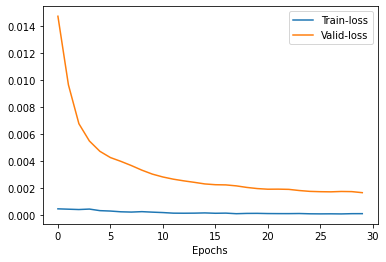

####################

Start training for stock: 1333
continuos shape: (1202, 9)  categorical shape: (1202, 4)
Epoch: <<< 0 >>>


C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.loc[:, ['RowId']] = txt_transfom.transform()
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Volume'] = df['Volume'].astype(float)
C:\Users\gilbe\Documents\TokyoStockEx\notebooks\..\preprocessing\preprocess.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Train metrics: {'mse': 0.008000321686267853, 'mae': 0.06985010206699371}
Validation metrics: {'mse': 0.0012389605399221182, 'mae': 0.029917754232883453}
Average train loss: 8.380474755540491e-05 | Average val loss: 0.00139359082095325
.................... End of epoch 0 ....................
Epoch: <<< 1 >>>
Train metrics: {'mse': 0.006359647028148174, 'mae': 0.062429871410131454}
Validation metrics: {'mse': 0.0014239461161196232, 'mae': 0.032381877303123474}
Average train loss: 7.73236621171236e-05 | Average val loss: 0.001599341630935669
.................... End of epoch 1 ....................
Epoch: <<< 2 >>>
Train metrics: {'mse': 0.008253008127212524, 'mae': 0.07529832422733307}
Validation metrics: {'mse': 0.0018621314084157348, 'mae': 0.03764215484261513}
Average train loss: 8.195480331778527e-05 | Average val loss: 0.002091847127303481
.................... End of epoch 2 ....................
Epoch: <<< 3 >>>
Train metrics: {'mse': 0.007388352416455746, 'mae': 0.06654489785432816}

In [ ]:
%%time
stocks = train_df['SecuritiesCode'].unique()
count = 0
BATCH_SIZE = 256

trainer = Trainer(model, optimizer_name='adam', lr=1.3333e-5)
torch.autograd.set_detect_anomaly(True)

for s in stocks:
    train_loader, val_dataloader = None, None
    if count > 20:
        break
    print(f'Start training for stock: {s}')

    train_dataloader, val_dataloader = dataloader_by_stock(
        train_df, s, batch_size=BATCH_SIZE, continous_cols=CONT_COLS)

    trainer.fit_epochs(
        train_dataloader, 
        val_dataloader, 
        use_cyclic_lr=True, 
        x_cat=True, 
        epochs=30
    )
    print('#' * 20)
    print()
    count += 1
    
    